# *Whispers* **of** **the** **Machine** - Poem Generation Project

    "The poet's eye, in a fine frenzy rolling,
    Doth glance from heaven to earth, from earth to heaven;
    And as imagination bodies forth
    The forms of things unknown, the poet’s pen
    Turns them to shapes, and gives to airy nothing
    A local habitation and a name."

    — A Midsummer Night’s Dream, Act 5, Scene 1

This project transforms algorithms into poets, using words inspired by the masters—Shakespeare, Frost, and beyond. Each line is a fusion of logic and art, where code meets creativity. Can a machine capture the soul of verse? Let’s find out.

In [ ]:
from PIL import Image

In [ ]:
# img = Image.open("/content/poem.jpg")
# img.convert("RGB").save("converted_image.jpg")

In [ ]:
# from IPython.display import Image
# display(Image("converted_image.jpg",width=1000, height=400))

## Downloading The Dataset

In [ ]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d tgdivy/poetry-foundation-poems

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/tgdivy/poetry-foundation-poems
License(s): GNU Affero General Public License 3.0
poetry-foundation-poems.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
#unziping the file
from zipfile import ZipFile
file_name = '/content/poetry-foundation-poems.zip'

with ZipFile(file_name, 'r') as zipextractor:
  zipextractor.extractall()
  print('Done')

Done


## Importing The Libraries

In [ ]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import math
import tensorflow as tf
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from PIL import Image
from sklearn.model_selection import train_test_split
from spacy.lang.en.stop_words import STOP_WORDS as stopwords
from sklearn.model_selection import GroupKFold
from keras.callbacks import EarlyStopping

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense,Flatten,Embedding,Dropout, LSTM, Embedding, BatchNormalization
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers


## Reading The Dataset

In [ ]:
data = pd.read_csv('/content/PoetryFoundationData.csv')
#data = data[:560] #tried with whole dataset, then it is too big, so took only first 520 poems
data = data[:300]
data.head(4)

,Unnamed: 0,Title,Poem,Poet,Tags
0,0,\r\r\n Objects Used to Prop...,"\r\r\nDog bone, stapler,\r\r\ncribbage board, ...",Michelle Menting,NaN
1,1,\r\r\n The New Church\r\r\n...,"\r\r\nThe old cupola glinted above the clouds,...",Lucia Cherciu,NaN
2,2,\r\r\n Look for Me\r\r\n ...,\r\r\nLook for me under the hood\r\r\nof that ...,Ted Kooser,NaN
3,3,\r\r\n Wild Life\r\r\n ...,"\r\r\nBehind the silo, the Mother Rabbit\r\r\n...",Grace Cavalieri,NaN


In [ ]:
#data['Poet'].value_counts()

In [ ]:
data.shape

(300, 5)

In [ ]:
poem_data = pd.DataFrame({'Poem':data['Poem'].values})
poem_data.sample(4)

,Poem
257,\r\r\nIn standing position\r\r\nwith arms to t...
250,\r\r\nbijan been dead 11 months & my blue marg...
49,\r\r\nOne day we will all be like this—the boa...
243,\r\r\nTo keep me from staying out late at nigh...


## Removing Lines

In [ ]:
poem_data['Poem'][0]

"\r\r\nDog bone, stapler,\r\r\ncribbage board, garlic press\r\r\n     because this window is loose—lacks\r\r\nsuction, lacks grip.\r\r\nBungee cord, bootstrap,\r\r\ndog leash, leather belt\r\r\n     because this window had sash cords.\r\r\nThey frayed. They broke.\r\r\nFeather duster, thatch of straw, empty\r\r\nbottle of Elmer's glue\r\r\n     because this window is loud—its hinges clack\r\r\nopen, clack shut.\r\r\nStuffed bear, baby blanket,\r\r\nsingle crib newel\r\r\n     because this window is split. It's dividing\r\r\nin two.\r\r\nVelvet moss, sagebrush,\r\r\nwillow branch, robin's wing\r\r\n     because this window, it's pane-less. It's only\r\r\na frame of air.\r\r\n"

In [ ]:
poem_data['Poem'] = poem_data['Poem'].apply(lambda x: x.splitlines())

In [ ]:
poem_data['Poem'][0]

['',
 '',
 'Dog bone, stapler,',
 '',
 'cribbage board, garlic press',
 '',
 '     because this window is loose—lacks',
 '',
 'suction, lacks grip.',
 '',
 'Bungee cord, bootstrap,',
 '',
 'dog leash, leather belt',
 '',
 '     because this window had sash cords.',
 '',
 'They frayed. They broke.',
 '',
 'Feather duster, thatch of straw, empty',
 '',
 "bottle of Elmer's glue",
 '',
 '     because this window is loud—its hinges clack',
 '',
 'open, clack shut.',
 '',
 'Stuffed bear, baby blanket,',
 '',
 'single crib newel',
 '',
 "     because this window is split. It's dividing",
 '',
 'in two.',
 '',
 'Velvet moss, sagebrush,',
 '',
 "willow branch, robin's wing",
 '',
 "     because this window, it's pane-less. It's only",
 '',
 'a frame of air.',
 '']

In [ ]:
poem_data['Poem'] = poem_data['Poem'].apply(lambda x: " ".join(x))

In [ ]:
poem_data['Poem'][0]

"  Dog bone, stapler,  cribbage board, garlic press       because this window is loose—lacks  suction, lacks grip.  Bungee cord, bootstrap,  dog leash, leather belt       because this window had sash cords.  They frayed. They broke.  Feather duster, thatch of straw, empty  bottle of Elmer's glue       because this window is loud—its hinges clack  open, clack shut.  Stuffed bear, baby blanket,  single crib newel       because this window is split. It's dividing  in two.  Velvet moss, sagebrush,  willow branch, robin's wing       because this window, it's pane-less. It's only  a frame of air. "

## Cleaning The Text

In [ ]:
!pip -q install contractions
import contractions
import unicodedata

In [ ]:
def remove_accented(x):
  x = unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return x

In [ ]:
def get_clean(X):
    X = str(X).lower().replace('\\', ' ').replace('_', ' ').replace(':', '')
    X = contractions.fix(X)
    X = X.replace('#', "")
    X = re.sub(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?',"",  X)
    X = re.sub(r'[^\w\d\s]+','', X)
    X = ' '.join(X.split())
    X = BeautifulSoup(X, 'lxml').get_text().strip()
    X = remove_accented(X)
    return X

In [ ]:
poem_data['Poem'] = poem_data['Poem'].apply(lambda x: get_clean(x))
poem_data['Poem'][0]

'dog bone stapler cribbage board garlic press because this window is looselacks suction lacks grip bungee cord bootstrap dog leash leather belt because this window had sash cords they frayed they broke feather duster thatch of straw empty bottle of elmers glue because this window is loudits hinges clack open clack shut stuffed bear baby blanket single crib newel because this window is split it is dividing in two velvet moss sagebrush willow branch robins wing because this window it is paneless it is only a frame of air'

## Word Cloud Representation


In [ ]:
# plt.rcParams['figure.figsize'] = [4,4]
# plt.rcParams['figure.dpi'] = 120
# sns.set(style='darkgrid')

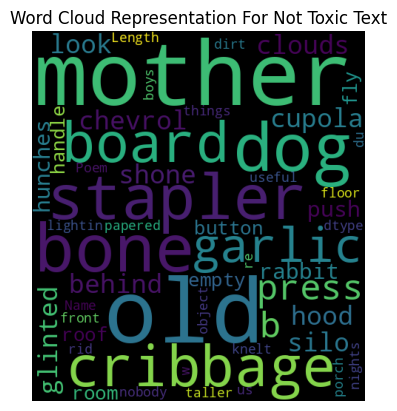

In [ ]:
poems = str(poem_data['Poem'])
word_cloud = WordCloud(width=450, height=500, max_font_size=120).generate(poems)
plt.imshow(word_cloud)
plt.title('Word Cloud Representation For Not Toxic Text')
plt.axis('off')
plt.show()

## Converting Text Into Numerical Form

In [ ]:
token = Tokenizer()
token.fit_on_texts(poem_data['Poem'])

In [ ]:
token.word_index

{'the': 1,
 'a': 2,
 'of': 3,
 'and': 4,
 'to': 5,
 'i': 6,
 'in': 7,
 'is': 8,
 'you': 9,
 'it': 10,
 'my': 11,
 'not': 12,
 'on': 13,
 'that': 14,
 'with': 15,
 'for': 16,
 'as': 17,
 'we': 18,
 'was': 19,
 'he': 20,
 'his': 21,
 'like': 22,
 'your': 23,
 'at': 24,
 'her': 25,
 'but': 26,
 'me': 27,
 'this': 28,
 'from': 29,
 'be': 30,
 'will': 31,
 'are': 32,
 'or': 33,
 'when': 34,
 'all': 35,
 'one': 36,
 'they': 37,
 'have': 38,
 'she': 39,
 'what': 40,
 'their': 41,
 'by': 42,
 'into': 43,
 'if': 44,
 'our': 45,
 'no': 46,
 'who': 47,
 'an': 48,
 'would': 49,
 'up': 50,
 'so': 51,
 'there': 52,
 'do': 53,
 'out': 54,
 'us': 55,
 'its': 56,
 'am': 57,
 'can': 58,
 'back': 59,
 'how': 60,
 'them': 61,
 'could': 62,
 'were': 63,
 'had': 64,
 'has': 65,
 'where': 66,
 'then': 67,
 'through': 68,
 'black': 69,
 'down': 70,
 'him': 71,
 'over': 72,
 'man': 73,
 'love': 74,
 'now': 75,
 'let': 76,
 'know': 77,
 'too': 78,
 'see': 79,
 'after': 80,
 'light': 81,
 'time': 82,
 'said': 83

In [ ]:
encoded_text = token.texts_to_sequences(poem_data['Poem'])

In [ ]:
encoded_text[0] # encoded fiirst poem

[366,
 1178,
 4126,
 4127,
 1426,
 2546,
 1179,
 98,
 28,
 266,
 8,
 4128,
 4129,
 2547,
 1180,
 4130,
 1427,
 4131,
 366,
 4132,
 2548,
 1428,
 98,
 28,
 266,
 64,
 4133,
 4134,
 37,
 1429,
 37,
 367,
 1843,
 4135,
 4136,
 3,
 1844,
 348,
 2549,
 3,
 4137,
 2550,
 98,
 28,
 266,
 8,
 4138,
 4139,
 2551,
 178,
 2551,
 1016,
 1845,
 598,
 653,
 1017,
 550,
 4140,
 4141,
 98,
 28,
 266,
 8,
 599,
 10,
 8,
 4142,
 7,
 111,
 2552,
 4143,
 4144,
 4145,
 712,
 4146,
 786,
 98,
 28,
 266,
 10,
 8,
 4147,
 10,
 8,
 87,
 2,
 1846,
 3,
 125]

In [ ]:
vocab_size = len(token.word_counts) + 1
print(f'Vocab Size: {vocab_size}')

Vocab Size: 10496


## Building The Data

In [ ]:
datalist = []
for d in encoded_text:
  if len(d)>1:
    for i in range(2, len(d)):
      datalist.append(d[:i])

In [ ]:
#make all possible m-grams

In [ ]:
datalist[:10]

[[366, 1178],
 [366, 1178, 4126],
 [366, 1178, 4126, 4127],
 [366, 1178, 4126, 4127, 1426],
 [366, 1178, 4126, 4127, 1426, 2546],
 [366, 1178, 4126, 4127, 1426, 2546, 1179],
 [366, 1178, 4126, 4127, 1426, 2546, 1179, 98],
 [366, 1178, 4126, 4127, 1426, 2546, 1179, 98, 28],
 [366, 1178, 4126, 4127, 1426, 2546, 1179, 98, 28, 266],
 [366, 1178, 4126, 4127, 1426, 2546, 1179, 98, 28, 266, 8]]

In [ ]:
#the input layer requires input in same length, so need to add padding

In [ ]:
max_length = 5
sequences = pad_sequences(datalist, maxlen=max_length, padding='pre')

In [ ]:
sequences[:10]

array([[   0,    0,    0,  366, 1178],
       [   0,    0,  366, 1178, 4126],
       [   0,  366, 1178, 4126, 4127],
       [ 366, 1178, 4126, 4127, 1426],
       [1178, 4126, 4127, 1426, 2546],
       [4126, 4127, 1426, 2546, 1179],
       [4127, 1426, 2546, 1179,   98],
       [1426, 2546, 1179,   98,   28],
       [2546, 1179,   98,   28,  266],
       [1179,   98,   28,  266,    8]], dtype=int32)

In [ ]:
seq_length = sequences.shape[1]
print(f'Sequence Length: {seq_length}')

Sequence Length: 5


## Dividing The Data

In [ ]:
X = sequences[:, :-1]
y = sequences[:, -1]

In [ ]:
X.shape #in these sequences, first four words are input

(62183, 4)

In [ ]:
y.shape #last word is the output, because we need to predict the next word

(62183,)

In [ ]:
y = to_categorical(y, num_classes=vocab_size) #one hot encoding

In [ ]:
y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Building The Model

In [ ]:
# model = Sequential()
# model.add(Embedding(vocab_size, 50))
# model.build(input_shape=(None, seq_length))  # Build the model explicitly.
# model.add(LSTM(100, return_sequences=True))
# model.add(LSTM(100))
# model.add(Dense(100, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dense(vocab_size, activation='softmax'))


In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, 50))
model.build(input_shape=(None, seq_length))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(50, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(vocab_size, activation='softmax'))


## Understanding The Model

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 5, 50)               │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 5, 50)               │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 50)                  │           2,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 50)                  │             200 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10496)               │         535,296 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,103,246 (4.21 MB)

 Trainable params: 1,103,146 (4.21 MB)

 Non-trainable params: 100 (400.00 B)

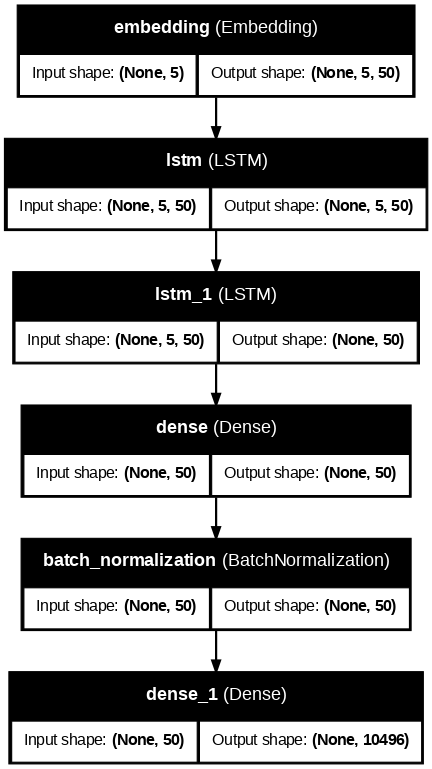

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True, dpi=80)

## Compiling The Model

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Training The Model

In [ ]:
#r = model.fit(X, y, batch_size=100, epochs=170, validation_split=0.2)

In [ ]:
r = model.fit(X, y, batch_size=100, epochs=170)

Epoch 1/170
622/622 ━━━━━━━━━━━━━━━━━━━━ 27s 20ms/step - accuracy: 0.0565 - loss: 8.1062
Epoch 2/170
622/622 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.0872 - loss: 6.4871
Epoch 3/170
622/622 ━━━━━━━━━━━━━━━━━━━━ 23s 20ms/step - accuracy: 0.1105 - loss: 6.1474
Epoch 4/170
622/622 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.1258 - loss: 5.8385
Epoch 5/170
622/622 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.1428 - loss: 5.5522
Epoch 6/170
622/622 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.1621 - loss: 5.2160
Epoch 7/170
622/622 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.1841 - loss: 4.9024
Epoch 8/170
622/622 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.2063 - loss: 4.6081
Epoch 9/170
622/622 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.2382 - loss: 4.2940
Epoch 10/170
622/622 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.2801 - loss: 3.9720
Epoch 11/170
622/622 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.3261 - loss: 3.6884
Epoch 12/170
622/622 

## Accuracy and Loss

In [ ]:
print(f'The traning accuracy of model is {math.floor(r.history["accuracy"][-1] * 100)} %')
print(f'The traning loss of model is {r.history["loss"][-1]:.3f}')

The traning accuracy of model is 93 %
The traning loss of model is 0.248


In [ ]:
# loss_LSTM, accuracy_LSTM = model.evaluate(X, y)
# print(f"Test Loss: {loss_LSTM}, Test Accuracy: {loss_LSTM}")

In [ ]:
plt.rcParams['figure.figsize'] = [22,6]
plt.rcParams['figure.dpi'] = 75

## Visualizing The Accuracy

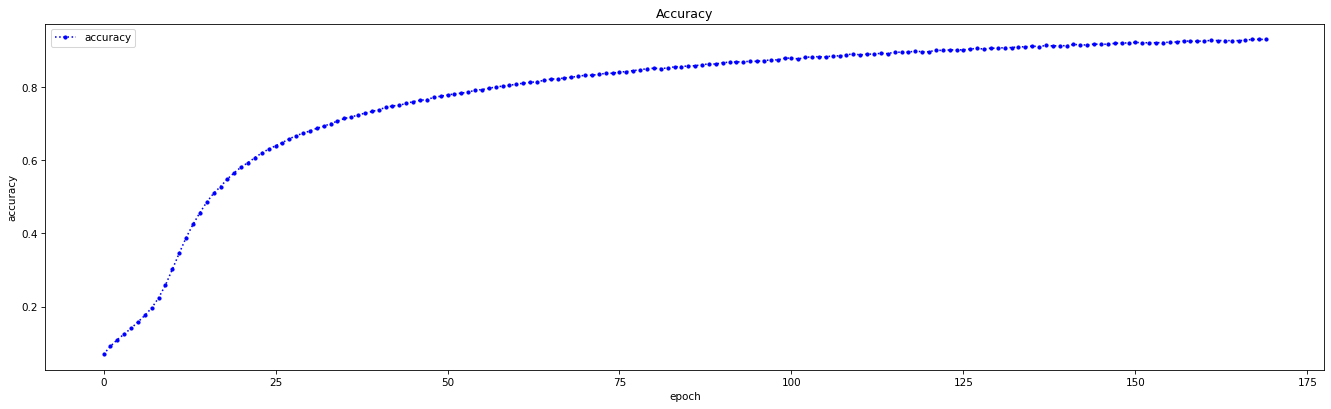

In [ ]:
plt.title('Accuracy')
plt.plot(r.history['accuracy'], ".:", label='accuracy', linewidth=1.5, color="blue")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

## Visualizing The Loss

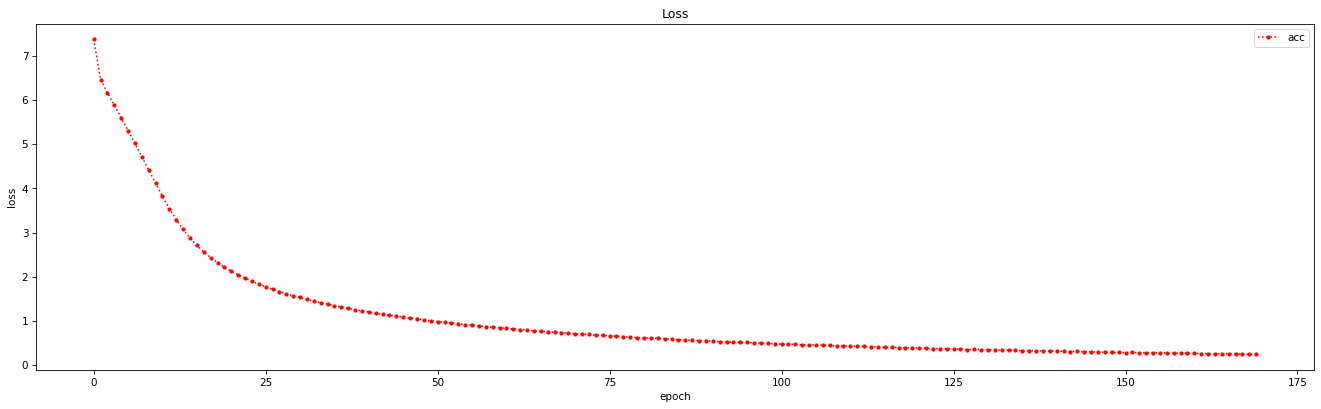

In [ ]:
plt.title('Loss')
plt.plot(r.history['loss'], ".:", label='acc', linewidth=1.5, color="red")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('/content/Poem_Writing_AI.h5')

# **PPL**

In [ ]:
loss, accuracy = model.evaluate(X, y)  # Evaluate on the same training data

# Step 3: Calculate perplexity using the loss
perplexity = np.exp(loss)
print(f"Perplexity on training data: {perplexity}")

1944/1944 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9189 - loss: 0.3279
Perplexity on training data: 1.3802658360240936


# **K-Fold corss validation**

In [ ]:
from sklearn.model_selection import KFold

num_folds = 5
kf = KFold(n_splits=num_folds)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

fold_no = 1
for train_idx, val_idx in kf.split(X):
    print(f"Training on fold {fold_no}...")

    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=50))
    model.build(input_shape=(None, seq_length))
    model.add(LSTM(30, return_sequences=True))
    model.add(LSTM(30))
    model.add(Dense(50, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(vocab_size, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), verbose=1)

    train_losses.append(history.history['loss'][-1])
    val_losses.append(history.history['val_loss'][-1])
    train_accuracies.append(history.history['accuracy'][-1])
    val_accuracies.append(history.history['val_accuracy'][-1])

    loss, accuracy = model.evaluate(X_val, y_val, verbose=0)
    print(f"Fold {fold_no}: Loss = {loss}, Accuracy = {accuracy}")

    fold_no += 1

avg_train_loss = np.mean(train_losses)
avg_val_loss = np.mean(val_losses)
avg_train_accuracy = np.mean(train_accuracies)
avg_val_accuracy = np.mean(val_accuracies)

print(f"Average Train Loss: {avg_train_loss}")
print(f"Average Validation Loss: {avg_val_loss}")
print(f"Average Train Accuracy: {avg_train_accuracy}")
print(f"Average Validation Accuracy: {avg_val_accuracy}")


Training on fold 1...


## Generating The Poems




In [ ]:
poetry_length = 10

def generate_poetry(seed_text, n_lines):

  for i in range(n_lines):
    text = []
    for _ in range(poetry_length):
      encoded = token.texts_to_sequences([seed_text])
      encoded = pad_sequences(encoded, maxlen=seq_length, padding='pre')

      y_pred = np.argmax(model.predict(encoded, verbose=0), axis=-1)

      predicted_word = ""
      for word, index in token.word_index.items(): #search the predicted word's index
        if index == y_pred:
          predicted_word = word
          break

      seed_text = seed_text + ' ' + predicted_word
      text.append(predicted_word)

    seed_text = text[-1]
    text = ' '.join(text)
    print(text)

## Result

In [ ]:
seed_text = 'Kiss'
print(f'Title: {seed_text}')
generate_poetry(seed_text, 5)

Title: Kiss
your mouth the voice of the ocean emperor finished it
being hard home into it the ground as her hair
you still and night room i smell off the splayed
his time the more maru is happens the world iceskating
on a frozen pond feet the transmits in the ranch


In [ ]:
seed_text = 'Once upon a time'
print(f'Title: {seed_text}')
generate_poetry(seed_text, 5)

Title: Once upon a time
until along it vernacular turning as if my surface have
does not matter of my bodies me just as at
pearl street station water been trance in blew ourselves friday
down the ferocious mean and you will me my beautiful
the time of forgive me praise i wrote could even


In [ ]:
seed_text = 'Beauty'
print(f'Title: {seed_text}')
generate_poetry(seed_text, 5)

Title: Beauty
early wishes it can walk anyone god and work but
the poem called two hot two sidewalk registers the world
on the joy time my name not my use on
if the nothings times down and others i say a
got like late it is the graveyard is an end


In [ ]:
model.save('Poem_Writing_AI.h5')

# **To Shakesperean Style**

## By using an already available shakesperean word dataset as a dictionary.

In [ ]:
!pip install kagglehub

In [ ]:
import kagglehub
#import jason

path = kagglehub.dataset_download("pronox/englishtoshakespearedict")
print("Path to dataset files:", path)

100%|██████████| 10.7k/10.7k [00:00<00:00, 3.79MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/pronox/englishtoshakespearedict/versions/2


In [ ]:
# Load the dataset into a DataFrame
dataset_path = f"{path}/english-to-shakespeare-dict.csv"
data = pd.read_csv(dataset_path)

In [ ]:
data.head(5)

,english,shakespearean
0,shorten,abate
1,blunt,abate
2,diminution,abatement
3,protest,abhor
4,disgust,abhor


In [ ]:
shakespearean_dict = dict(zip(data['english'], data['shakespearean']))

In [ ]:
def save_dictionary(dictionary, filename='shakespearean_dict.json'):
    with open(filename, 'w') as file:
        json.dump(dictionary, file)

save_dictionary(shakespearean_dict)

In [ ]:
def load_dictionary(filename='shakespearean_dict.json'):
    with open(filename, 'r') as file:
        return json.load(file)

shakespearean_dict = load_dictionary()

## **Remark:** Add another small fallback dictionary with more common words which are not in the downloaded dataset.

In [ ]:
def translate_to_shakespearean(text, vocab, fallback_vocab):
    words = text.split()
    translated_words = []

    for word in words:
        # Step 1: Check in the primary dictionary (from CSV)
        translated_word = vocab.get(word.lower(), None)

        # Step 2: If not in the primary dictionary, check in the fallback dictionary
        if not translated_word:
            translated_word = fallback_vocab.get(word.lower(), word)  # Default to the original word if not found

        translated_words.append(translated_word)

    return ' '.join(translated_words)


fallback_dict = {
    "you": "thou",
    "your": "thy",
    "are": "art",
    "has": "hast",
    "going": "gait",
    "to": "to",
    "the": "thee",
    "market": "marketplace",
    "hello": "hark",
    "friend": "companion",
    "house": "dwelling",
    "love": "affection",
    "good": "virtuous",
    "bad": "wicked",
    "happy": "joyful",
    "sad": "sorrowful",
}

# Example
modern_text = "you are going to the market and love your good house"
shakespearean_text = translate_to_shakespearean(modern_text, shakespearean_dict, fallback_dict)

print(f"Modern Text: {modern_text}")
print(f"Shakespearean Text: {shakespearean_text}")


Modern Text: you are going to the market and love your good house
Shakespearean Text: thou bin gait to thee marketplace and affect thy virtuous dwelling


In [ ]:
#the same function with return
poetry_length = 10

def generate_poetry_(seed_text, n_lines):
    poem = []  # Initialize a list to store the generated poem

    for i in range(n_lines):
        text = []
        for _ in range(poetry_length):
            encoded = token.texts_to_sequences([seed_text])
            encoded = pad_sequences(encoded, maxlen=seq_length, padding='pre')

            y_pred = np.argmax(model.predict(encoded, verbose=0), axis=-1)

            predicted_word = ""
            for word, index in token.word_index.items():
                if index == y_pred:
                    predicted_word = word
                    break

            seed_text = seed_text + ' ' + predicted_word
            text.append(predicted_word)

        seed_text = text[-1]  # Update seed_text for the next line
        line = ' '.join(text)  # Convert list of words to a single string
        poem.append(line)  # Add the line to the poem
        print(line)  # Print the generated line

    return poem  # Return the complete poem as a list of lines


In [ ]:
# Generate the poem and translate it
seed_text = 'Kiss'
print(f"Title: {seed_text}")
poem = generate_poetry_(seed_text, 5)

print("\n")

translated_poem = []

if poem:
    for line in poem:
        translated_line = translate_to_shakespearean(line, shakespearean_dict, fallback_dict)
        translated_poem.append(translated_line)  # Add translated line to the list

    print("Translated Poem:")
    print("\n".join(translated_poem))
else:
    print("No poem was generated.")


Title: Kiss
your mouth the voice of the ocean emperor finished it
being hard home into it the ground as her hair
you still and night room i smell off the splayed
his time the more maru is happens the world iceskating
on a frozen pond feet the transmits in the ranch


Translated Poem:
thy mouth thee breast of thee ocean keisar finished it
being hard home into it thee ground as her hair
thou limbeck and night room i smell off thee splayed
his time thee more maru is happens thee world iceskating
on a frozen pond feet thee transmits in thee ranch


In [ ]:
#next check for other models for poem generation and translation

# **RNN**

In [ ]:
model_RNN = Sequential([
    Embedding(input_dim=vocab_size, output_dim=50, input_length=seq_length),
    SimpleRNN(100, return_sequences=False),
    Dense(vocab_size, activation='softmax')
    # predict probabilities for each word in vocab
])

# Build the model explicitly
model_RNN.build(input_shape=(None, seq_length))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
model_RNN.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 4, 50)               │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (None, 100)                 │          15,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10496)               │       1,060,096 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,599,996 (6.10 MB)

 Trainable params: 1,599,996 (6.10 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile the model
model_RNN.compile(
    loss='categorical_crossentropy',  # because y is one-hot encoded
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
#model_RNN.fit(X, y, epochs=170, batch_size=100, validation_split=0.2)
model_RNN.fit(X, y, epochs=170, batch_size=100)

Epoch 1/170
498/498 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.0600 - loss: 7.7276 - val_accuracy: 0.0659 - val_loss: 7.1698
Epoch 2/170
498/498 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.0767 - loss: 6.7367 - val_accuracy: 0.0682 - val_loss: 7.1938
Epoch 3/170
498/498 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.0798 - loss: 6.3853 - val_accuracy: 0.0785 - val_loss: 7.2380
Epoch 4/170
498/498 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.0967 - loss: 5.9932 - val_accuracy: 0.0773 - val_loss: 7.3519
Epoch 5/170
498/498 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.1110 - loss: 5.6418 - val_accuracy: 0.0788 - val_loss: 7.4919
Epoch 6/170
498/498 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.1209 - loss: 5.3577 - val_accuracy: 0.0771 - val_loss: 7.6135
Epoch 7/170
498/498 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.1412 - loss: 5.0698 - val_accuracy: 0.0730 - val_loss: 7.7370
Epoch 8/170
498/498 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.1580 - loss: 4.8172 - val_ac

In [ ]:
model_RNN.fit(X, y, epochs=100, batch_size=50)

Epoch 1/100
1244/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.0640 - loss: 7.5214
Epoch 2/100
1244/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.0761 - loss: 6.6449
Epoch 3/100
1244/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.0993 - loss: 6.1279
Epoch 4/100
1244/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.1170 - loss: 5.6198
Epoch 5/100
1244/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.1419 - loss: 5.1832
Epoch 6/100
1244/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.1783 - loss: 4.7700
Epoch 7/100
1244/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.2290 - loss: 4.3759
Epoch 8/100
1244/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.2795 - loss: 4.0265
Epoch 9/100
1244/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.3376 - loss: 3.6781
Epoch 10/100
1244/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.3819 - loss: 3.3795
Epoch 11/100
1244/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.4339 - loss: 3.0813
Epoch 12/100
124

In [ ]:
loss, accuracy = model_RNN.evaluate(X, y)
#print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

1944/1944 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9684 - loss: 0.1286


In [ ]:
model_RNN.save('Poem_Writing_AI_RNN.h5')

In [ ]:
#model = load_model('/content/Poem_Writing_AI.h5')

In [ ]:
perplexity = np.exp(loss)
print(f"Perplexity on training data: {perplexity}")

Perplexity on training data: 1.1336798375438537


In [ ]:
def generate_text(seed_text, model, tokenizer, max_length=50, line_length=7):
    poem = seed_text
    word_count = len(seed_text.split())

    for _ in range(max_length):
        tokenized = tokenizer.texts_to_sequences([seed_text])[0]

        if len(tokenized) > X.shape[1]:
            tokenized = tokenized[-X.shape[1]:]

        tokenized = np.pad(tokenized, (X.shape[1] - len(tokenized), 0), mode='constant')

        predictions = model.predict(tokenized[np.newaxis, :], verbose=0)
        next_token = np.argmax(predictions, axis=-1)[0]

        next_word = tokenizer.index_word[next_token]
        seed_text += " " + next_word
        poem += " " + next_word
        word_count += 1

        if word_count % line_length == 0:
            poem += "\n"

        if next_word == '<eos>':
            break

    return poem

In [ ]:
seed = "love"
print(f"{seed}")
generated_poem = generate_text(seed, model_RNN, token)
print(generated_poem)

love
love in the halakhas an thousand day
 of river happiness burning while my side
 so is everything to the brink of
 insanity let them all sleep and dream
 that the god of war has brought
 them riches in the shape of gold
 nuggets only to find in the morning
 an empty


In [ ]:
#looks performing well, but overfitting

In [ ]:
from keras.layers import Embedding, SimpleRNN, Dense, Dropout
from keras.regularizers import l2

# Define the RNN model with regularization and dropout
model_RNN_ = Sequential([
    Embedding(input_dim=vocab_size, output_dim=50, input_length=X.shape[1]),
    SimpleRNN(128, dropout=0.1, recurrent_dropout=0.1),
    Dense(vocab_size, activation='softmax', kernel_regularizer=l2(0.001))
])

model_RNN_.build(input_shape=(None, X.shape[1]))

model_RNN_.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_RNN_.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 4, 50)               │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 100)                 │          15,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10496)               │       1,060,096 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,599,996 (6.10 MB)

 Trainable params: 1,599,996 (6.10 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_RNN_.fit(X, y, epochs=170, batch_size=100, validation_split=0.2)

Epoch 1/170
498/498 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.0589 - loss: 8.1346 - val_accuracy: 0.0585 - val_loss: 7.4374
Epoch 2/170
498/498 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.0645 - loss: 7.3950 - val_accuracy: 0.0585 - val_loss: 7.4594
Epoch 3/170
498/498 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.0641 - loss: 7.3696 - val_accuracy: 0.0584 - val_loss: 7.4769
Epoch 4/170
498/498 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.0640 - loss: 7.3484 - val_accuracy: 0.0585 - val_loss: 7.4793
Epoch 5/170
498/498 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.0648 - loss: 7.2975 - val_accuracy: 0.0584 - val_loss: 7.4265
Epoch 6/170
498/498 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.0645 - loss: 7.1972 - val_accuracy: 0.0584 - val_loss: 7.4417
Epoch 7/170
498/498 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.0664 - loss: 7.1315 - val_accuracy: 0.0594 - val_loss: 7.4750
Epoch 8/170
498/498 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.0732 - loss: 7.0888 - val_ac

In [ ]:
loss_, accuracy_ = model_RNN_.evaluate(X, y)
print(f"Test Loss: {loss_}, Test Accuracy: {accuracy_}")

In [ ]:
#not overfitting, but need to train more since accuracy is law and loss is high

# **GRU**

In [ ]:
from tensorflow.keras.layers import GRU, Dense, Embedding

model_GRU = Sequential([
    Embedding(input_dim=vocab_size, output_dim=100),
    GRU(50, return_sequences=False),
    Dense(vocab_size, activation='softmax')
])

model_GRU.build(input_shape=(None, X.shape[1]))

In [ ]:
model_GRU.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 4, 100)              │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 50)                  │          22,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10496)               │         535,296 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,607,696 (6.13 MB)

 Trainable params: 1,607,696 (6.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_GRU.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model_GRU.fit(X, y , epochs=170, batch_size=100)

Epoch 1/170
622/622 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.0608 - loss: 7.7721
Epoch 2/170
622/622 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.0627 - loss: 6.8487
Epoch 3/170
622/622 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.0751 - loss: 6.6054
Epoch 4/170
622/622 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.0904 - loss: 6.3596
Epoch 5/170
622/622 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.1015 - loss: 6.1507
Epoch 6/170
622/622 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.1110 - loss: 5.9681
Epoch 7/170
622/622 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.1197 - loss: 5.7499
Epoch 8/170
622/622 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.1288 - loss: 5.5633
Epoch 9/170
622/622 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.1404 - loss: 5.3610
Epoch 10/170
622/622 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.1532 - loss: 5.1720
Epoch 11/170
622/622 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.1657 - loss: 5.0170
Epoch 12/170
622/622 ━━━━━

In [ ]:
model_GRU.fit(X, y , epochs=100, batch_size=50)

Epoch 1/100
1244/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.0632 - loss: 7.5914
Epoch 2/100
1244/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.0757 - loss: 6.7098
Epoch 3/100
1244/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.0889 - loss: 6.3869
Epoch 4/100
1244/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.1085 - loss: 6.0625
Epoch 5/100
1244/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.1209 - loss: 5.7857
Epoch 6/100
1244/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.1341 - loss: 5.5092
Epoch 7/100
1244/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.1470 - loss: 5.2625
Epoch 8/100
1244/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.1677 - loss: 4.9949
Epoch 9/100
1244/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.1944 - loss: 4.7123
Epoch 10/100
1244/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.2190 - loss: 4.4864
Epoch 11/100
1244/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.2521 - loss: 4.2569
Epoch 12/100


In [ ]:
model_GRU.fit(X, y , epochs=100, batch_size=50, validation_split=0.2)

Epoch 1/100
995/995 ━━━━━━━━━━━━━━━━━━━━ 44s 41ms/step - accuracy: 0.0618 - loss: 7.6785 - val_accuracy: 0.0585 - val_loss: 7.1690
Epoch 2/100
995/995 ━━━━━━━━━━━━━━━━━━━━ 78s 37ms/step - accuracy: 0.0638 - loss: 6.7966 - val_accuracy: 0.0671 - val_loss: 7.1878
Epoch 3/100
995/995 ━━━━━━━━━━━━━━━━━━━━ 41s 37ms/step - accuracy: 0.0758 - loss: 6.5188 - val_accuracy: 0.0770 - val_loss: 7.2239
Epoch 4/100
995/995 ━━━━━━━━━━━━━━━━━━━━ 42s 38ms/step - accuracy: 0.0944 - loss: 6.2387 - val_accuracy: 0.0876 - val_loss: 7.2524
Epoch 5/100
995/995 ━━━━━━━━━━━━━━━━━━━━ 40s 37ms/step - accuracy: 0.1148 - loss: 5.9280 - val_accuracy: 0.0901 - val_loss: 7.4091
Epoch 6/100
995/995 ━━━━━━━━━━━━━━━━━━━━ 35s 35ms/step - accuracy: 0.1220 - loss: 5.6502 - val_accuracy: 0.0909 - val_loss: 7.5366
Epoch 7/100
995/995 ━━━━━━━━━━━━━━━━━━━━ 35s 35ms/step - accuracy: 0.1373 - loss: 5.3738 - val_accuracy: 0.0902 - val_loss: 7.6663
Epoch 8/100
995/995 ━━━━━━━━━━━━━━━━━━━━ 40s 40ms/step - accuracy: 0.1538 - loss: 5

KeyboardInterrupt: 

In [ ]:
model_GRU.save('Poem_Writing_AI_GRU.h5')

In [ ]:
loss, accuracy = model_GRU.evaluate(X, y)
#print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

1944/1944 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9077 - loss: 0.4350


In [ ]:
#model = load_model('/content/Poem_Writing_AI.h5')

In [ ]:
perplexity = np.exp(loss)
print(f"Perplexity on training data: {perplexity}")

Perplexity on training data: 1.5376405401756716


In [ ]:
def generate_poem_GRU(seed_text, model, tokenizer, max_length=50, temperature=1.0):

    generated_text = seed_text

    for _ in range(max_length):
        tokenized = tokenizer.texts_to_sequences([seed_text])[0]

        if len(tokenized) > model_GRU.input_shape[1]:
            tokenized = tokenized[-model_GRU.input_shape[1]:]

        tokenized = np.pad(tokenized, (model_GRU.input_shape[1] - len(tokenized), 0), mode='constant')

        # Predict the next word probabilities
        predictions = model.predict(tokenized[np.newaxis, :], verbose=0)[0]

        # Apply temperature to control randomness
        predictions = np.log(predictions + 1e-10) / temperature
        predictions = np.exp(predictions) / np.sum(np.exp(predictions))

        # Sample the next word's token
        next_token = np.random.choice(range(len(predictions)), p=predictions)

        # Map the token back to a word
        next_word = tokenizer.index_word.get(next_token, "<unk>")

        # Stop if end-of-sequence token is generated
        if next_word == '<eos>':
            break

        # Add the word to the generated text
        seed_text += " " + next_word
        generated_text += " " + next_word

        # Break the line for better readability (every 7 words)
        if len(generated_text.split()) % 7 == 0:
            generated_text += "\n"

    return generated_text


In [ ]:
loss_GRU, accuracy_GRU = model_GRU.evaluate(X, y)
# print(f"Test Loss: {loss_GRU}, Test Accuracy: {accuracy_GRU}")

1944/1944 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.8966 - loss: 0.4810


In [ ]:
seed = "love"
print(f"{seed}")
generated_poem_ = generate_poem_GRU(seed, model_GRU, token)
print(generated_poem_)

love
love should roll up they poor her
 too children to break which if you
 were mine for a car new she
 made it and alone and through a
 hard why keep all i sit on
 a clipper blood and still glimpse all
 of this man who gave me as
 you will


In [ ]:
seed = "Once upon a"
print(f"{seed}")
generated_poem_ = generate_poem_GRU(seed, model_GRU, token)
print(generated_poem_)

Once upon a
Once upon a more than pink high
 times which i appropriate be such a
 single color imaginary devil and imaginary son
 the time not to be and through
 the word straight and the attention in
 a busted speaker suppose you had to
 wipe sweat from the brow of a
 righteous body to would


In [ ]:
seed = "Flowers bloom"
print(f"{seed}")
generated_poem_ = generate_poem_GRU(seed, model_GRU, token)
print(generated_poem_)

Flowers bloom
Flowers bloom of border wall peri of
 love but they saw her back from
 every plow soon as my child why
 is around of course moses summer like
 snow and sleeping a friend like without
 many too place many rude comfort by
 her your bank whatever boy the god
 is so small


# **Analysis**

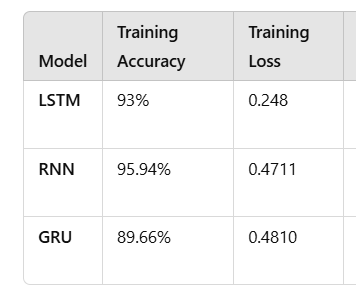

***Generated Text Quality:***

**LSTM:** Produces more structured text with slightly better grammar but struggles with meaning and coherence/logical flow.

**RNN:**Slightly better text structure than LSTM but fails to maintain semantic meaning or logical flow.

**GRU:** Generates text with little logical structure, struggling the most with grammar and coherence.


***Based on the results:***

LSTM appears to be the best for this, as it has the lowest loss and produces relatively coherent text compared to the others. Its architecture allows it to handle longer dependencies better than RNNs and GRUs.

RNN performs decently but seems to struggle with overfitting. It also lacks the capacity to capture long-term dependencies, making it less suitable for creative text generation.

NOTE: Due to the memory issue, only 300 poems were considered.

# **Furthur attempts to improve the LSTM model**

## **Remark:** Below is a fold cross validation on the LSTM model. This includes early stopping if overfits. It seems overfitting, yet try some solutions as:

## 1. Changing the LSTM layers as simplifying and making them complex
## 2. Inculde dropout and regulations
## 3. Increase sequence length
## 4. Try increasing dataset(but the session crashes)

## Even with all these options, it keeps overfitting! Yet the result is good as seen before!

# **Attempt 01**

In [ ]:
# Here assume each sample is a separate group, so we assign each sample a unique group ID, so the lines of the poem do not shuffle, instead the whole poem considers.
groups = np.arange(len(X))  # This creates an array from 0 to len(X)-1

y = to_categorical(y, num_classes=vocab_size)

num_folds = 5
group_kfold = GroupKFold(n_splits=num_folds)
fold_no = 1

# Store metrics for each fold
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for train_idx, test_idx in group_kfold.split(X, y, groups):
    print(f"Training on fold {fold_no}...")

    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # For each fold
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=50))
    model.build(input_shape=(None, seq_length))
    model.add(LSTM(50, return_sequences=True))
    model.add(LSTM(50))
    model.add(Dense(50, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(vocab_size, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Use EarlyStopping to avoid overfitting
    #early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(X_train, y_train, epochs=100, batch_size=80, verbose=1, validation_data=(X_test, y_test))

    # Record training and validation metrics
    train_losses.append(history.history['loss'])
    val_losses.append(history.history['val_loss'])
    train_accuracies.append(history.history['accuracy'])
    val_accuracies.append(history.history['val_accuracy'])

    # Evaluate on test set
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"Fold {fold_no}: Loss = {loss}, Accuracy = {accuracy}")

    fold_no += 1

Training on fold 1...
Epoch 1/100
511/511 ━━━━━━━━━━━━━━━━━━━━ 27s 40ms/step - accuracy: 0.0543 - loss: 8.1995 - val_accuracy: 0.0762 - val_loss: 6.9062
Epoch 2/100
511/511 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step - accuracy: 0.0775 - loss: 6.5477 - val_accuracy: 0.0859 - val_loss: 6.9185
Epoch 3/100
511/511 ━━━━━━━━━━━━━━━━━━━━ 20s 34ms/step - accuracy: 0.0940 - loss: 6.1661 - val_accuracy: 0.0819 - val_loss: 6.9752
Epoch 4/100
511/511 ━━━━━━━━━━━━━━━━━━━━ 22s 37ms/step - accuracy: 0.1178 - loss: 5.8448 - val_accuracy: 0.0861 - val_loss: 7.1819
Epoch 5/100
511/511 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step - accuracy: 0.1430 - loss: 5.5031 - val_accuracy: 0.0799 - val_loss: 7.3512
Epoch 6/100
511/511 ━━━━━━━━━━━━━━━━━━━━ 22s 38ms/step - accuracy: 0.1677 - loss: 5.1536 - val_accuracy: 0.0763 - val_loss: 7.6595
Fold 1: Loss = 6.906203269958496, Accuracy = 0.07621563225984573
Training on fold 2...
Epoch 1/100
512/512 ━━━━━━━━━━━━━━━━━━━━ 25s 37ms/step - accuracy: 0.0551 - loss: 8.2174 - val_accuracy: 

### **Tried with PPL but session crashes!**

In [ ]:
import torch
import torch.nn.functional as F


groups = np.arange(len(X))
y = to_categorical(y, num_classes=vocab_size)

num_folds = 5
group_kfold = GroupKFold(n_splits=num_folds)
fold_no = 1


train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
perplexities = []

# Function to compute Perplexity
def calculate_perplexity(model, X_test, y_test):
    model.eval()
    total_loss = 0
    total_words = 0

    with torch.no_grad():
        for i in range(len(X_test)):
            inputs = X_test[i]  # test input sequence
            target = y_test[i]  # test target (next token)

            # Forward pass
            outputs = model(inputs)
            logits = outputs.logits[:, :-1, :]  # Ignore the last token for loss calculation
            target_tokens = target[:, 1:]  # Shift target by one position

            log_probs = F.log_softmax(logits, dim=-1)
            target_log_probs = log_probs.gather(2, target_tokens.unsqueeze(-1)).squeeze(-1)

            avg_log_prob = target_log_probs.mean()
            perplexity = torch.exp(-avg_log_prob)  # Apply exponentiation

            total_loss += perplexity.item()

    return total_loss / len(X_test)

for train_idx, test_idx in group_kfold.split(X, y, groups):
    print(f"Training on fold {fold_no}...")

    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Build and compile the model
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=50))
    model.build(input_shape=(None, seq_length))
    model.add(LSTM(50, return_sequences=True))
    model.add(LSTM(50))
    model.add(Dense(50, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(vocab_size, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # EarlyStopping to avoid overfitting
    #early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(X_train, y_train, epochs=50, batch_size=30, verbose=1, validation_data=(X_test, y_test))

    train_losses.append(history.history['loss'])
    val_losses.append(history.history['val_loss'])
    train_accuracies.append(history.history['accuracy'])
    val_accuracies.append(history.history['val_accuracy'])

    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"Fold {fold_no}: Loss = {loss}, Accuracy = {accuracy}")

    # Calculate Perplexity for the test set
    ppl_value = calculate_perplexity(model, X_test, y_test)
    perplexities.append(ppl_value)
    print(f"Fold {fold_no}: Perplexity = {ppl_value:.2f}")

    fold_no += 1

# After all folds, you can compute the average Perplexity across all folds
average_ppl = np.mean(perplexities)
print(f"Average Perplexity across all folds: {average_ppl:.2f}")


Training on fold 1...


In [ ]:
# # plot the loss and accuracy curves
# plt.figure(figsize=(12, 6))

# # Plot training vs validation loss
# plt.subplot(1, 2, 1)
# for i in range(num_folds):
#     plt.plot(train_losses[i], label=f'Train Fold {i+1}')
#     plt.plot(val_losses[i], label=f'Validation Fold {i+1}')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('Training and Validation Loss')
# plt.legend()

# # Plot training vs validation accuracy
# plt.subplot(1, 2, 2)
# for i in range(num_folds):
#     plt.plot(train_accuracies[i], label=f'Train Fold {i+1}')
#     plt.plot(val_accuracies[i], label=f'Validation Fold {i+1}')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.title('Training and Validation Accuracy')
# plt.legend()

# plt.tight_layout()
# plt.show()

# **Attempt 02**

In [ ]:
max_length_ = 10
sequences_ = pad_sequences(datalist, maxlen=max_length_, padding='pre')

In [ ]:
sequences_[:10]

array([[   0,    0,    0,    0,    0,    0,    0,    0,  416, 1314],
       [   0,    0,    0,    0,    0,    0,    0,  416, 1314, 5134],
       [   0,    0,    0,    0,    0,    0,  416, 1314, 5134, 5135],
       [   0,    0,    0,    0,    0,  416, 1314, 5134, 5135, 1515],
       [   0,    0,    0,    0,  416, 1314, 5134, 5135, 1515, 2324],
       [   0,    0,    0,  416, 1314, 5134, 5135, 1515, 2324, 1142],
       [   0,    0,  416, 1314, 5134, 5135, 1515, 2324, 1142,  106],
       [   0,  416, 1314, 5134, 5135, 1515, 2324, 1142,  106,   30],
       [ 416, 1314, 5134, 5135, 1515, 2324, 1142,  106,   30,  292],
       [1314, 5134, 5135, 1515, 2324, 1142,  106,   30,  292,    8]],
      dtype=int32)

In [ ]:
seq_length_ = sequences_.shape[1]
print(f'Sequence Length: {seq_length_}')

Sequence Length: 10


In [ ]:
X_ = sequences_[:, :-1]
y_ = sequences_[:, -1]

In [ ]:
X_.shape

(82342, 9)

In [ ]:
y_.shape

(82342,)

In [ ]:
y_ = to_categorical(y_, num_classes=vocab_size)

In [ ]:
y_

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
model_LSTM2 = Sequential()
model_LSTM2.add(Embedding(input_dim=vocab_size, output_dim=50))
model_LSTM2.build(input_shape=(None, seq_length))
model_LSTM2.add(LSTM(50, return_sequences=False))
model_LSTM2.add(Dropout(0.3))
model_LSTM2.add(Dense(64, kernel_regularizer=regularizers.l2(0.01), activation='relu'))
model_LSTM2.add(Dropout(0.5))
model_LSTM2.add(Dense(vocab_size, activation='softmax'))

optimizer = Adam(learning_rate=0.0001)
model_LSTM2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
model_LSTM2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 10, 50)              │         627,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 100)                 │          60,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           6,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 12546)               │         815,490 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,509,654 (5.76 MB)

 Trainable params: 1,509,654 (5.76 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_LSTM2.fit(X, y, epochs=50, validation_split=0.2, callbacks=[early_stopping])

# **Remark:**
## Since validation loss increases instead of decreasing, it seems like overfitting. Tried to increase the dataset, but the session crashes.

## Tried droput, regularization and increasing the sequence length.

In [ ]:
poetry_length = 10

def generate_poetry_LSTM02(seed_text, n_lines):

  for i in range(n_lines):
    text = []
    for _ in range(poetry_length):
      encoded = token.texts_to_sequences([seed_text])
      encoded = pad_sequences(encoded, maxlen=seq_length, padding='pre')

      y_pred = np.argmax(model_LSTM2.predict(encoded, verbose=0), axis=-1)

      predicted_word = ""
      for word, index in token.word_index.items(): #search the predicted word's index
        if index == y_pred:
          predicted_word = word
          break

      seed_text = seed_text + ' ' + predicted_word
      text.append(predicted_word)

    seed_text = text[-1]
    text = ' '.join(text)
    print(text)

In [ ]:
seed_text = 'Life'
print(f'Title: {seed_text}')
generate_poetry_LSTM02(seed_text, 5)

Title: Life
i am a cat i said i was a mouth
as i was a poem to the moon i have
been a woman to be a man who is a
man who is a cat i said i was a
man who is a cat i said i was a


# **New Model!**

In [ ]:
poem_new_df = pd.read_csv('/content/PoetryFoundationData.csv')

In [ ]:
# # Define minimum poem count threshold
# min_poems = 30

# # Count poems per poet
# poet_counts = poem_new_df["Poet"].value_counts()

# # Keep only poets with at least 'min_poems' poems
# selected_poets = poet_counts[poet_counts >= min_poems].index

In [ ]:
# Define minimum poem count threshold
min_poems = 50

# Count poems per poet
poet_counts = poem_new_df["Poet"].value_counts()

# Keep only poets with at least 'min_poems' poems
selected_poets = poet_counts[poet_counts >= min_poems].index


In [ ]:
selected_poets

Index(['William Shakespeare', 'Alfred, Lord Tennyson', 'Emily Dickinson',
       'William Wordsworth'],
      dtype='object', name='Poet')

In [ ]:
selected_poets = [poet for poet in selected_poets if poet != "Emily Dickinson"]

In [ ]:
selected_poets

['William Shakespeare', 'Alfred, Lord Tennyson', 'William Wordsworth']

In [ ]:
df_filtered = poem_new_df[poem_new_df["Poet"].isin(selected_poets)].copy()

era_mapping = {
    "William Shakespeare": "Elizabethan",
    "Alfred, Lord Tennyson": "Victorian",
   # "Emily Dickinson": "Modern",
    "William Wordsworth": "Romantic",
}

df_filtered["era"] = df_filtered["Poet"].map(era_mapping)

df_filtered = df_filtered[["Poem", "Title", "Poet", "era"]]

df_filtered.to_csv("filtered_poems.csv", index=False)

df_filtered.head()



,Poem,Title,Poet,era
880,\r\r\nLet the bird of loudest lay On the sole ...,\r\r\n The Phoenix and the ...,William Shakespeare,Elizabethan
2002,"\r\r\nNo, Time, thou shalt not boast that I do...","\r\r\n Sonnet 123: No, Time...",William Shakespeare,Elizabethan
2003,\r\r\n’Tis better to be vile than vile esteeme...,\r\r\n Sonnet 121: 'Tis bet...,William Shakespeare,Elizabethan
2004,\r\r\nBeshrew that heart that makes my heart t...,\r\r\n Sonnet 133: Beshrew ...,William Shakespeare,Elizabethan
2005,"\r\r\nO, call not me to justify the wrongThat ...","\r\r\n Sonnet 139: O, call ...",William Shakespeare,Elizabethan


In [ ]:
# selected_poets = [
#     "William Shakespeare", "John Donne",  # Elizabethan
#     "William Wordsworth", "William Blake",  # Romantic
#     "Alfred, Lord Tennyson", "Robert Browning" # Victorian
# ]

# df_filtered = poem_new_df[poem_new_df["Poet"].isin(selected_poets)].copy()

# era_mapping = {
#     "William Shakespeare": "Elizabethan",
#     "John Donne": "Elizabethan",
#     "William Wordsworth": "Romantic",
#     "William Blake": "Romantic",
#     "Alfred, Lord Tennyson": "Victorian",
#     "Robert Browning": "Victorian"
# }

# df_filtered["era"] = df_filtered["Poet"].map(era_mapping)

# df_filtered = df_filtered[["Poem", "Title", "Poet", "era"]]

# df_filtered.to_csv("filtered_poems.csv", index=False)

# df_filtered.head()


,Poem,Title,Poet,era
880,\r\r\nLet the bird of loudest lay On the sole ...,\r\r\n The Phoenix and the ...,William Shakespeare,Elizabethan
898,"\r\r\nHamelin Town's in Brunswick, By famou...",\r\r\n The Pied Piper of Ha...,Robert Browning,Victorian
1226,\r\r\nAnd did those feet in ancient time Walk ...,"\r\r\n Jerusalem [""And did ...",William Blake,Romantic
2002,"\r\r\nNo, Time, thou shalt not boast that I do...","\r\r\n Sonnet 123: No, Time...",William Shakespeare,Elizabethan
2003,\r\r\n’Tis better to be vile than vile esteeme...,\r\r\n Sonnet 121: 'Tis bet...,William Shakespeare,Elizabethan


In [ ]:
df_filtered['Poet'].value_counts()

,count
Poet,
William Shakespeare,85
"Alfred, Lord Tennyson",73
William Wordsworth,51


In [ ]:
df_filtered['Poem'] = df_filtered['Poem'].apply(lambda x: x.splitlines())

In [ ]:
df_filtered['Poem']

,Poem
880,\r\r\nLet the bird of loudest lay On the sole ...
2002,"\r\r\nNo, Time, thou shalt not boast that I do..."
2003,\r\r\n’Tis better to be vile than vile esteeme...
2004,\r\r\nBeshrew that heart that makes my heart t...
2005,"\r\r\nO, call not me to justify the wrongThat ..."
...,...
13420,\r\r\n\r\r\n\r\r\n\r\r\n(from Cymbeline)\r\r\n...
13421,\r\r\n\r\r\n\r\r\n\r\r\n(from Twelfth Night)\r...
13422,\r\r\n\r\r\n\r\r\n\r\r\n(from Henry VIII)\r\r\...
13423,\r\r\n\r\r\n\r\r\n\r\r\n(from Measure for Meas...


In [ ]:
df_filtered['Poem'] = df_filtered['Poem'].apply(lambda x: " ".join(x))

In [ ]:
df_filtered['Poem']

,Poem
880,Let the bird of loudest lay On the sole Arab...
898,"Hamelin Town's in Brunswick, By famous Ha..."
1153,I. ...
1226,And did those feet in ancient time Walk upon...
1362,The sorrow of true love is a great sorrow A...
...,...
13421,(from Twelfth Night) O Mistress...
13422,(from Henry VIII) Orpheus with ...
13423,(from Measure for Measure) Take...
13424,(from As You Like It) Under the...


In [ ]:
!pip -q install contractions
import contractions
import unicodedata

In [ ]:
def remove_accented(x):
  x = unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return x

In [ ]:
def get_clean(X):
    X = str(X).lower().replace('\\', ' ').replace('_', ' ').replace(':', '')
    X = contractions.fix(X)
    X = X.replace('#', "")
    X = re.sub(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?',"",  X)
    X = re.sub(r'[^\w\d\s]+','', X)
    X = ' '.join(X.split())
    X = BeautifulSoup(X, 'lxml').get_text().strip()
    X = remove_accented(X)
    return X

In [ ]:
df_filtered['Poem'] = df_filtered['Poem'].apply(lambda x: get_clean(x))
df_filtered['Poem']

,Poem
880,let the bird of loudest lay on the sole arabia...
2002,no time thou shalt not boast that i do changet...
2003,it is better to be vile than vile esteemedwhen...
2004,beshrew that heart that makes my heart to groa...
2005,o call not me to justify the wrongthat thy unk...
...,...
13420,from cymbeline hark hark the lark at heavens g...
13421,from twelfth night o mistress mine where are y...
13422,from henry viii orpheus with his lute made tre...
13423,from measure for measure take oh take those li...


In [ ]:
elizabethan_poems = " ".join(df_filtered[df_filtered['era'] == 'Elizabethan']['Poem'])
romantic_poems = " ".join(df_filtered[df_filtered['era'] == 'Romantic']['Poem'])
victorian_poems = " ".join(df_filtered[df_filtered['era'] == 'Victorian']['Poem'])

def generate_word_cloud(poems, title):
    wordcloud = WordCloud(width=450, height=500, max_font_size=120).generate(poems)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()


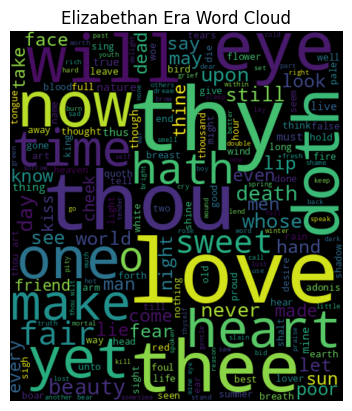

In [ ]:
generate_word_cloud(elizabethan_poems, 'Elizabethan Era Word Cloud')

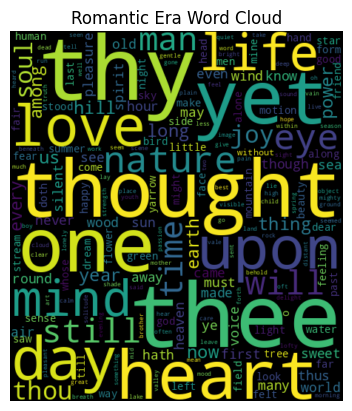

In [ ]:
generate_word_cloud(romantic_poems, 'Romantic Era Word Cloud')

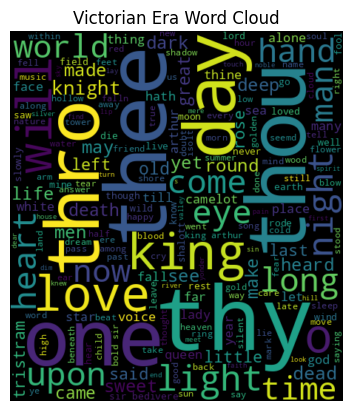

In [ ]:
generate_word_cloud(victorian_poems, 'Victorian Era Word Cloud')

In [ ]:
# Tokenization
all_poems = []
labels = []
for _, row in df_filtered.iterrows():
    poem = row["Poem"]
    era = row["era"]
    all_poems.append(f"<{era}> {poem}")
    labels.append(era)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_poems)
total_words = len(tokenizer.word_index) + 1


In [ ]:
all_poems[0]

'<Elizabethan> let the bird of loudest lay on the sole arabian tree herald sad and trumpet be to whose sound chaste wings obey but thou shrieking harbinger foul precurrer of the fiend augur of the fevers end to this troop come thou not near from this session interdict every fowl of tyrant wing save the eagle featherd king keep the obsequy so strict let the priest in surplice white that defunctive music can be the deathdivining swan lest the requiem lack his right and thou trebledated crow that thy sable gender makst with the breath thou givst and takst mongst our mourners shalt thou go here the anthem doth commence love and constancy is dead phoenix and the turtle fled in a mutual flame from hence so they lovd as love in twain had the essence but in one two distincts division none number there in love was slain hearts remote yet not asunder distance and no space was seen twixt this turtle and his queen but in them it were a wonder so between them love did shine that the turtle saw his 

In [ ]:
total_words

20038

In [ ]:
# Convert to sequences
input_sequences = []
for line in all_poems:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

In [ ]:
input_sequences[:10]

[[166, 91],
 [166, 91, 1],
 [166, 91, 1, 474],
 [166, 91, 1, 474, 3],
 [166, 91, 1, 474, 3, 4590],
 [166, 91, 1, 474, 3, 4590, 236],
 [166, 91, 1, 474, 3, 4590, 236, 22],
 [166, 91, 1, 474, 3, 4590, 236, 22, 1],
 [166, 91, 1, 474, 3, 4590, 236, 22, 1, 1341],
 [166, 91, 1, 474, 3, 4590, 236, 22, 1, 1341, 6029]]

In [ ]:
# Padding
#max_sequence_length = max([len(seq) for seq in input_sequences])

In [ ]:
#max_sequence_length

9743

In [ ]:
max_sequence_length = 5

In [ ]:
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_length, padding='pre')

In [ ]:
X, y = input_sequences[:, :-1], input_sequences[:, -1]
y = tf.keras.utils.to_categorical(y, num_classes=total_words)

In [ ]:
model_new = Sequential([
    Embedding(total_words, 50),
    LSTM(50, return_sequences=True),
    LSTM(50),
    Dense(total_words, activation='softmax')
])
model_new.build(input_shape=(None, max_sequence_length - 1))

In [ ]:
model_new.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 4, 50)               │         687,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 4, 50)               │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 13744)               │         700,944 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,428,544 (5.45 MB)

 Trainable params: 1,428,544 (5.45 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_new.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model_new.fit(X, y, epochs=100, batch_size=80, verbose=1, validation_split=0.2)

Epoch 1/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 39s 47ms/step - accuracy: 0.0530 - loss: 7.6565 - val_accuracy: 0.0589 - val_loss: 7.2631
Epoch 2/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.0574 - loss: 6.7925 - val_accuracy: 0.0589 - val_loss: 7.3783
Epoch 3/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 42s 47ms/step - accuracy: 0.0587 - loss: 6.6672 - val_accuracy: 0.0680 - val_loss: 7.4763
Epoch 4/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 44s 52ms/step - accuracy: 0.0701 - loss: 6.5449 - val_accuracy: 0.0681 - val_loss: 7.5045
Epoch 5/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 35s 43ms/step - accuracy: 0.0716 - loss: 6.4228 - val_accuracy: 0.0680 - val_loss: 7.5822
Epoch 6/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 30s 41ms/step - accuracy: 0.0759 - loss: 6.2770 - val_accuracy: 0.0710 - val_loss: 7.6384
Epoch 7/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.0770 - loss: 6.1667 - val_accuracy: 0.0691 - val_loss: 7.6826
Epoch 8/100
728/728 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.0822 - loss: 6

In [ ]:
#model_new.fit(X, y, epochs=100, batch_size=80, verbose=1)

Epoch 1/100
955/955 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.0559 - loss: 7.5964
Epoch 2/100
955/955 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.0568 - loss: 6.8454
Epoch 3/100
955/955 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.0652 - loss: 6.6952
Epoch 4/100
955/955 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.0700 - loss: 6.5560
Epoch 5/100
955/955 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.0760 - loss: 6.4061
Epoch 6/100
955/955 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.0763 - loss: 6.2758
Epoch 7/100
955/955 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.0798 - loss: 6.1425
Epoch 8/100
955/955 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.0843 - loss: 6.0094
Epoch 9/100
955/955 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.0908 - loss: 5.8582
Epoch 10/100
955/955 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.0955 - loss: 5.7308
Epoch 11/100
955/955 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.1026 - loss: 5.6010
Epoch 12/100
955/95

In [ ]:
#model_new.fit(X, y, epochs=50, batch_size=30, verbose=1)

In [ ]:
# from sklearn.model_selection import GroupKFold

# eras = ["Elizabethan", "Elizabethan", "Victorian", "Modern"]

# # Create mappings for group IDs (based on era)
# era_to_group = {"Elizabethan": 0, "Victorian": 1, "Modern": 2}
# groups = [era_to_group[era] for era in eras]  # Group IDs for each poem

# # Create n-grams
# input_sequences = []
# group_ids = []  # Initialize list for group IDs

# for i, poem in enumerate(all_poems):
#     token_list = tokenizer.texts_to_sequences([poem])[0]
#     # Generate n-grams for each poem
#     for j in range(1, len(token_list)):
#         n_gram_sequence = token_list[:j+1]
#         input_sequences.append(n_gram_sequence)
#         group_ids.append(groups[i])  # Assign the same group ID for each n-gram

# # Prepare X (features) and y (labels)
# X = np.array([seq[:-1] for seq in input_sequences])  # Features (n-grams)
# y = np.array([seq[-1] for seq in input_sequences])  # Labels (next word)
# y = tf.keras.utils.to_categorical(y, num_classes=total_words)  # One-hot encoding

# # Ensure that X, y, and groups have consistent lengths
# assert len(X) == len(y) == len(group_ids), "Inconsistent lengths"

# # Group K-Fold Cross Validation considering eras
# group_kfold = GroupKFold(n_splits=3)  # Adjust number of folds as needed
# fold_no = 1

# # Perform Group K-Fold cross-validation
# for train_idx, test_idx in group_kfold.split(X, y, group_ids):
#     print(f"\nTraining on fold {fold_no}...")

#     X_train, X_test = X[train_idx], X[test_idx]
#     y_train, y_test = y[train_idx], y[test_idx]

#     # Build your model
#     model = Sequential([
#         Embedding(input_dim=total_words, output_dim=50),
#         LSTM(20, return_sequences=True),
#         LSTM(20),
#         Dense(50, activation='relu'),
#         BatchNormalization(),
#         Dense(total_words, activation='softmax')
#     ])
#     model.build(input_shape=(None, X_train.shape[1]))

#     model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#     # Train the model
#     history = model.fit(X_train, y_train, epochs=10, batch_size=80, verbose=1, validation_data=(X_test, y_test))

#     # Evaluate the model
#     loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
#     print(f"Fold {fold_no}: Loss = {loss:.4f}, Accuracy = {accuracy:.4f}")

#     fold_no += 1


In [ ]:
groups = np.arange(len(X))

num_unique_groups = len(np.unique(groups))

num_folds = min(5, num_unique_groups)
group_kfold = GroupKFold(n_splits=num_folds)
fold_no = 1

for train_idx, test_idx in group_kfold.split(X, y, groups):
    print(f"\n Training on fold {fold_no}...")

    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model = Sequential([
        Embedding(input_dim=total_words, output_dim=50),
        LSTM(20, return_sequences=True),
        LSTM(20),
        Dense(50, activation='relu'),
        BatchNormalization(),
        Dense(total_words, activation='softmax')
    ])
    model.build(input_shape=(None, max_sequence_length - 1))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train, y_train, epochs=10, batch_size=80, verbose=1, validation_data=(X_test, y_test))

    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f" Fold {fold_no}: Loss = {loss:.4f}, Accuracy = {accuracy:.4f}")

    fold_no += 1


 Training on fold 1...


In [ ]:
def generate_poem_new(seed_text, era, next_words=10):
    seed_text = f"<{era}> {seed_text}"
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_length-1, padding='pre')
        predicted = model_new.predict(token_list, verbose=0)
        next_word = tokenizer.index_word[np.argmax(predicted)]
        seed_text += " " + next_word
    return seed_text.replace(f"<{era}> ", "")

print(generate_poem_new("O fairest maiden", "Elizabethan", 10))

O fairest maiden me for their shoulders reels to garnerd seeks the pearl


In [ ]:
# Function to sample words based on temperature (with randomness)
def sample_with_temperature(predictions, temperature=1.0):
    predictions = np.asarray(predictions).astype('float64')
    predictions = np.log(predictions + 1e-7) / temperature
    exp_preds = np.exp(predictions)
    predictions = exp_preds / np.sum(exp_preds)

    next_word_index = np.random.choice(len(predictions), p=predictions)
    return next_word_index

def generate_poem_new(seed_text, era, num_lines=5, next_words=10, temperature=1.0):
    poem = []
    current_text = f"<{era}> {seed_text}"

    for line_num in range(num_lines):
        line = current_text.strip()  # Initialize each line with seed text, clean up spaces
        generated_words = set()

        for word_num in range(next_words):
            token_list = tokenizer.texts_to_sequences([line])[0]
            token_list = pad_sequences([token_list], maxlen=max_sequence_length-1, padding='pre')

            if len(token_list[0]) > max_sequence_length-1:
                token_list = token_list[:, -max_sequence_length+1:]

            predicted = model_new.predict(token_list, verbose=0)[0]

            next_word_index = sample_with_temperature(predicted, temperature=temperature)
            next_word = tokenizer.index_word[next_word_index]

            while next_word in generated_words:
                next_word_index = sample_with_temperature(predicted, temperature=temperature)
                next_word = tokenizer.index_word[next_word_index]

            line += " " + next_word
            generated_words.add(next_word)  # Add the word to the set to track repetition

        poem.append(line.replace(f"<{era}> ", ""))

        current_text = " ".join(line.split()[-2:])  # Keep the last two words of the line for continuity

    return "\n".join(poem)

generated_poem_elizabethan = generate_poem_new("O fairest maiden", "Elizabethan", num_lines=5, next_words=10, temperature=1.2)
print(generated_poem_elizabethan)

O fairest maiden me had into its breath which slept undone growth and
growth and many the haft dimmd of hers and lies a blessed
a blessed shadow not her life has cruel forgot now toward the
toward the live and piercing deeply shalt king to me be lust
be lust among the feud pass to thee moant and echoes armour


In [ ]:
generated_poem_romantic = generate_poem_new("O fairest maiden", "Romantic", num_lines=5, next_words=10, temperature=1.2)
print(generated_poem_romantic)

O fairest maiden the distance drove his master hence we zone rapt dear
rapt dear the a truth thy lips of love gentlemen with ships
with ships fight though holy for every duty sometimes but mens responsive
mens responsive bright for courtesy repeal me hid as these turtle steal
turtle steal one light so all it seemed to greet thee band


In [ ]:
generated_poem_victorian = generate_poem_new("O fairest maiden", "Victorian", num_lines=5, next_words=10, temperature=1.2)
print(generated_poem_victorian)

O fairest maiden addition thee alien evn to some for your dominion which
dominion which when she springs with beat and up till shines then
shines then i see their notice is round to the limit of
limit of the sweet boy flowd where o i be impress wert
impress wert many the dear carol dwells in a cold tell brake


In [ ]:
#do cross validation with increased epochs, and give an explanation to this part. end the project interestingly with a quote also

# **Extra**

# Generate a model using only Shakepearean poems to learn the language




In [ ]:
data_to_S = pd.read_csv('/content/PoetryFoundationData.csv')

In [ ]:
data_to_S.head(4)

,Unnamed: 0,Title,Poem,Poet,Tags
0,0,\r\r\n Objects Used to Prop...,"\r\r\nDog bone, stapler,\r\r\ncribbage board, ...",Michelle Menting,NaN
1,1,\r\r\n The New Church\r\r\n...,"\r\r\nThe old cupola glinted above the clouds,...",Lucia Cherciu,NaN
2,2,\r\r\n Look for Me\r\r\n ...,\r\r\nLook for me under the hood\r\r\nof that ...,Ted Kooser,NaN
3,3,\r\r\n Wild Life\r\r\n ...,"\r\r\nBehind the silo, the Mother Rabbit\r\r\n...",Grace Cavalieri,NaN


In [ ]:
poet_main = data_to_S[["Title","Poem","Poet"]]

In [ ]:
poet_main.head(1)

,Title,Poem,Poet
0,\r\r\n Objects Used to Prop...,"\r\r\nDog bone, stapler,\r\r\ncribbage board, ...",Michelle Menting


In [ ]:
print(f"Missing values:\n\n{poet_main.isnull().sum()}")

Missing values:

Title    0
Poem     0
Poet     0
dtype: int64


In [ ]:
print(f"Poets' work:\n\n{poet_main['Poet'].value_counts()}")

Poets' work:

Poet
William Shakespeare      85
Alfred, Lord Tennyson    73
Emily Dickinson          51
William Wordsworth       51
Rae Armantrout           49
                         ..
George Kalogeris          1
Gowann                    1
Seán Hewitt               1
Michelle Boisseau         1
Nadra Mabrouk             1
Name: count, Length: 3128, dtype: int64


In [ ]:
shakespearean_poems = poet_main[poet_main['Poet'] == 'William Shakespeare']['Poem']

In [ ]:
shakespearean_poems.head(2)

,Poem
880,\r\r\nLet the bird of loudest lay On the sole ...
2002,"\r\r\nNo, Time, thou shalt not boast that I do..."


In [ ]:
token_w = Tokenizer()
token_w.fit_on_texts(shakespearean_poems)

In [ ]:
token_w.word_index

{'\r\r': 1,
 'the': 2,
 'and': 3,
 'to': 4,
 'of': 5,
 'in': 6,
 'a': 7,
 'that': 8,
 'his': 9,
 'i': 10,
 'with': 11,
 'my': 12,
 'her': 13,
 'is': 14,
 'she': 15,
 'he': 16,
 'not': 17,
 'but': 18,
 'thou': 19,
 'for': 20,
 'thy': 21,
 'as': 22,
 'be': 23,
 'this': 24,
 'so': 25,
 'love': 26,
 'it': 27,
 'all': 28,
 'by': 29,
 'on': 30,
 'me': 31,
 'from': 32,
 'thee': 33,
 'no': 34,
 'like': 35,
 'their': 36,
 'him': 37,
 'you': 38,
 'when': 39,
 'they': 40,
 'are': 41,
 'which': 42,
 'have': 43,
 'doth': 44,
 'more': 45,
 'now': 46,
 'or': 47,
 'shall': 48,
 'then': 49,
 'will': 50,
 'what': 51,
 '’': 52,
 'one': 53,
 'yet': 54,
 'was': 55,
 'do': 56,
 'if': 57,
 'nor': 58,
 'heart': 59,
 'eyes': 60,
 'at': 61,
 'hath': 62,
 'did': 63,
 'them': 64,
 'fair': 65,
 'time': 66,
 'o': 67,
 'sweet': 68,
 'where': 69,
 'your': 70,
 'death': 71,
 'eye': 72,
 'still': 73,
 'make': 74,
 'who': 75,
 'whose': 76,
 'were': 77,
 'upon': 78,
 'being': 79,
 'beauty': 80,
 'day': 81,
 'mine': 82,
 

In [ ]:
encoded_text_w = token_w.texts_to_sequences(shakespearean_poems)

In [ ]:
encoded_text_w[0]

[1,
 84,
 2,
 585,
 5,
 1757,
 348,
 30,
 2,
 1758,
 1759,
 476,
 752,
 280,
 3,
 1760,
 23,
 4,
 76,
 477,
 1761,
 753,
 754,
 18,
 19,
 1762,
 1763,
 171,
 1764,
 5,
 2,
 1061,
 1765,
 5,
 2,
 1766,
 209,
 4,
 24,
 1767,
 109,
 19,
 17,
 586,
 32,
 24,
 1768,
 1769,
 95,
 1770,
 5,
 755,
 1062,
 349,
 2,
 1063,
 1771,
 223,
 281,
 2,
 1772,
 25,
 1064,
 84,
 2,
 1773,
 6,
 1774,
 136,
 8,
 1775,
 398,
 89,
 23,
 2,
 71,
 1065,
 1776,
 478,
 2,
 1777,
 399,
 9,
 312,
 3,
 19,
 1066,
 1778,
 1779,
 8,
 21,
 1067,
 1780,
 1781,
 11,
 2,
 154,
 19,
 1782,
 3,
 1783,
 1068,
 101,
 1784,
 193,
 19,
 210,
 137,
 2,
 1069,
 44,
 1070,
 26,
 3,
 1785,
 14,
 120,
 756,
 3,
 2,
 757,
 479,
 6,
 7,
 758,
 759,
 32,
 480,
 25,
 40,
 1071,
 22,
 26,
 6,
 400,
 90,
 2,
 1786,
 18,
 6,
 53,
 178,
 1787,
 1072,
 224,
 1788,
 91,
 6,
 26,
 55,
 282,
 1789,
 1790,
 54,
 17,
 1073,
 1791,
 3,
 34,
 1792,
 55,
 138,
 1793,
 24,
 757,
 3,
 9,
 350,
 18,
 6,
 64,
 27,
 77,
 7,
 481,
 25,
 482,
 64,
 26,
 6

In [ ]:
vocab_size_w = len(token_w.word_counts) + 1
print(f'Vocab Size: {vocab_size_w}')

Vocab Size: 4619


In [ ]:
#Prepare input/output sequences (Next word prediction)
X_w = []
y_w = []

In [ ]:
sequence_length = 5
for poem in encoded_text_w:
    for i in range(sequence_length, len(poem)):
        X_w.append(poem[:i])  # Input sequence
        y_w.append(poem[i])  # Output word

In [ ]:
X_w[:10]

[[1, 84, 2, 585, 5],
 [1, 84, 2, 585, 5, 1757],
 [1, 84, 2, 585, 5, 1757, 348],
 [1, 84, 2, 585, 5, 1757, 348, 30],
 [1, 84, 2, 585, 5, 1757, 348, 30, 2],
 [1, 84, 2, 585, 5, 1757, 348, 30, 2, 1758],
 [1, 84, 2, 585, 5, 1757, 348, 30, 2, 1758, 1759],
 [1, 84, 2, 585, 5, 1757, 348, 30, 2, 1758, 1759, 476],
 [1, 84, 2, 585, 5, 1757, 348, 30, 2, 1758, 1759, 476, 752],
 [1, 84, 2, 585, 5, 1757, 348, 30, 2, 1758, 1759, 476, 752, 280]]

In [ ]:
y_w[:10]

[1757, 348, 30, 2, 1758, 1759, 476, 752, 280, 3]

In [ ]:
X_w = pad_sequences(X_w)  # Make all sequences the same length
y_w = to_categorical(y_w, num_classes=vocab_size_w)  # One-hot encode labels

In [ ]:
model_w = Sequential()
model_w.add(Embedding(vocab_size_w, 50))
model_w.build(input_shape=(None, sequence_length))
model_w.add(LSTM(150, return_sequences=True))
model_w.add(LSTM(150))
model_w.add(Dense(150, activation='relu'))
model_w.add(Dense(vocab_size_w, activation='softmax'))


In [ ]:
model_w.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 5, 50)               │         230,950 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 5, 150)              │         120,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 150)                 │         180,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 150)                 │          22,650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4619)                │         697,469 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,252,269 (4.78 MB)

 Trainable params: 1,252,269 (4.78 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_w.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
#model_w.fit(X_w, y_w, epochs=50, batch_size=10, validation_split=0.2)

In [ ]:
def generate_shakespearean_text(seed_text, model, tokenizer, max_sequence_length=5):
    # Tokenize seed text and pad it to match the input length
    sequence = tokenizer.texts_to_sequences([seed_text])
    sequence = pad_sequences(sequence, maxlen=max_sequence_length, padding='pre')

    predicted = model.predict(sequence, verbose=0)
    predicted_word = tokenizer.index_word[predicted.argmax()]  # Get word corresponding to predicted index

    return predicted_word

In [ ]:
seed = "love"
shakespearean_word = generate_shakespearean_text(seed, model_w, token_w)
print(f"Generated Shakespearean word: {shakespearean_word}")